## DQN으로 학습하는 카트폴 

### lib

In [14]:
import os
import math
import random
import pickle

from collections import deque, namedtuple
from typing import List, Tuple
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from qnet import DQN
import gymnasium as gym

### HYPERPARAMS

In [15]:
ENV_ID = "CartPole-v1"
SEED = 42
EPISODES = 500
MAX_STEPS = 500
REPLAY_CAPACITY = 10000
BATCH_SIZE = 64
GAMMA = 0.99
LR = 1e-3
TARGET_SYNC = 200       
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 4000        

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Set Env, Agent 

In [16]:
env = gym.make(ENV_ID)
env.action_space.seed(SEED)
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]  # 4: [x, x_dot, theta, theta_dot]

### DQN network

In [17]:
policy_net = DQN(state_dim, n_actions).to(DEVICE)
target_net = DQN(state_dim, n_actions).to(DEVICE)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)

### Replay Buffer for Off-line Learning

In [18]:
Transition = namedtuple('Transition', ('state','action','reward','next_state','done'))


class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buf = deque(maxlen=capacity)

    def push(self, *args):
        self.buf.append(Transition(*args))

    def sample(self, batch_size: int) -> Transition:
        idxs = np.random.choice(len(self.buf), batch_size, replace=False)
        batch = [self.buf[i] for i in idxs]
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buf)

replay = ReplayBuffer(REPLAY_CAPACITY)

In [19]:
# 상태 스냅샷 저장용 리스트
state_snapshots: List[np.ndarray] = []
failure_snapshots: List[np.ndarray] = []

# =========================
# 3) Epsilon-Greedy 정책
# =========================
def epsilon_by_frame(frame_idx: int) -> float:
    # smooth decay of epsilon
    return EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * frame_idx / EPS_DECAY)


def select_action(state: np.ndarray, frame_idx: int) -> int:
    eps = epsilon_by_frame(frame_idx)
    if random.random() < eps:
        return env.action_space.sample()
    with torch.no_grad():
        s = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        q = policy_net(s)  # [1, n_actions]
        return int(q.argmax(dim=1).item())


# =========================
# 4) 학습 루프
# =========================
def optimize_model():
    if len(replay) < BATCH_SIZE:
        return
    batch = replay.sample(BATCH_SIZE)

    state_batch = torch.tensor(np.vstack(batch.state), dtype=torch.float32, device=DEVICE)
    action_batch = torch.tensor(batch.action, dtype=torch.int64, device=DEVICE).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=DEVICE).unsqueeze(1)
    next_state_batch = torch.tensor(np.vstack(batch.next_state), dtype=torch.float32, device=DEVICE)
    done_batch = torch.tensor(batch.done, dtype=torch.float32, device=DEVICE).unsqueeze(1)

    # Q(s,a)
    q_values = policy_net(state_batch).gather(1, action_batch)

    # max_a' Q_target(s',a')
    with torch.no_grad():
        next_q = target_net(next_state_batch).max(dim=1, keepdim=True)[0]
        target = reward_batch + (1.0 - done_batch) * GAMMA * next_q

    loss = nn.SmoothL1Loss()(q_values, target)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 10.0)
    optimizer.step()


def train_dqn():
    frame_idx = 0
    total_rewards = []
    best_reward_model, best_reward = None, -float('inf')

    for ep in range(EPISODES):
        state, _ = env.reset(seed=SEED + ep)
        ep_reward = 0.0
        for t in range(MAX_STEPS):
            frame_idx += 1
            # 학습 데이터 분포 파악을 위해 상태를 모아둡니다 (LIME용)
            state_before_step = state.copy()
            state_snapshots.append(state_before_step)

            action = select_action(state, frame_idx)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward

            if done:
                failure_snapshots.append(state_before_step)

            replay.push(state, action, reward, next_state, float(done))
            state = next_state

            optimize_model()

            if frame_idx % TARGET_SYNC == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

        # 최고 보상 모델 저장
        if ep_reward > best_reward:
            best_reward = ep_reward
            best_reward_model = policy_net.state_dict()

        total_rewards.append(ep_reward)

        # 10 에피소드마다 결과 출력
        if (ep + 1) % 10 == 0:
            print(f"[Episode {ep+1:3d}] reward={ep_reward:.1f}, epsilon={epsilon_by_frame(frame_idx):.3f}")

    return best_reward_model, total_rewards


best_reward_model, total_rewards = train_dqn()


[Episode  10] reward=23.0, epsilon=0.926
[Episode  20] reward=19.0, epsilon=0.863
[Episode  30] reward=14.0, epsilon=0.828
[Episode  40] reward=100.0, epsilon=0.740
[Episode  50] reward=15.0, epsilon=0.684
[Episode  60] reward=56.0, epsilon=0.617
[Episode  70] reward=64.0, epsilon=0.560
[Episode  80] reward=150.0, epsilon=0.478
[Episode  90] reward=178.0, epsilon=0.381
[Episode 100] reward=42.0, epsilon=0.336
[Episode 110] reward=94.0, epsilon=0.289
[Episode 120] reward=57.0, epsilon=0.256
[Episode 130] reward=172.0, epsilon=0.215
[Episode 140] reward=146.0, epsilon=0.175
[Episode 150] reward=129.0, epsilon=0.139
[Episode 160] reward=142.0, epsilon=0.116
[Episode 170] reward=149.0, epsilon=0.097
[Episode 180] reward=14.0, epsilon=0.088
[Episode 190] reward=14.0, epsilon=0.079
[Episode 200] reward=99.0, epsilon=0.072
[Episode 210] reward=118.0, epsilon=0.067
[Episode 220] reward=119.0, epsilon=0.062
[Episode 230] reward=37.0, epsilon=0.060
[Episode 240] reward=20.0, epsilon=0.060
[Episo

In [20]:
def ma(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

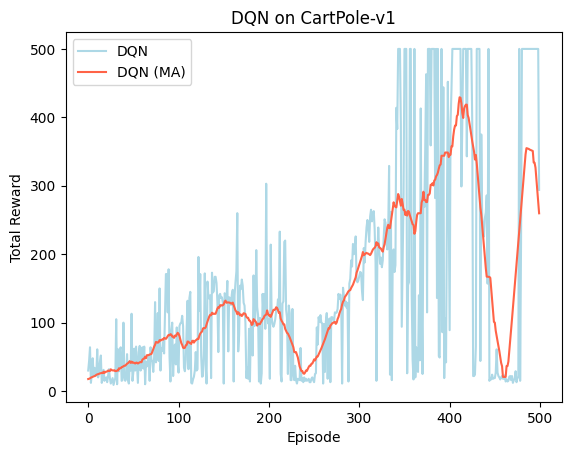

In [21]:
plt.plot(total_rewards, label='DQN', color='lightblue')
plt.plot(ma(total_rewards,30), label='DQN (MA)', color='tomato')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN on CartPole-v1')
plt.legend()
plt.show()

In [22]:
len(state_snapshots)

77165

### 모델, 데이터 저장

In [23]:
os.makedirs('model', exist_ok=True)
torch.save(best_reward_model, 'model/cartpole_dqn_best.pth')

In [24]:
os.makedirs('snapshots', exist_ok=True)
with open('snapshots/cartpole_state_snapshots.pkl', 'wb') as f:
    pickle.dump(state_snapshots, f)

with open('snapshots/cartpole_failure_snapshots.pkl', 'wb') as f:
    pickle.dump(failure_snapshots, f)
